# Imports

In [1]:
import os
import cv2
import pickle
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from dataset.cache import cache

In [2]:
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.python.keras.applications import VGG16
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

# Load Data

In [3]:
random.seed(2) # To always load the same images in each dataset split

In [4]:
def load_coco(input_path, split=0.8):
    """ Load coco dataset
        :params input_path: path to the parsed coco file
        :params split: split between training and validation dataset
    """
    with open(input_path, 'rb') as file:
        coco_raw = pickle.load(file)
    image_to_captions = coco_raw['image_to_captions']
    image_to_file = coco_raw['image_to_file']
    
    # split dataset
    img_ids = list(image_to_file.keys())
    split_idx = int(len(img_ids) * split)
    random.shuffle(img_ids)
    img_ids_train = img_ids[:split_idx]
    img_ids_val = img_ids[split_idx:]
    
    # training dataset
    filenames_train = []
    captions_train = []
    for img_id in img_ids_train:
        filenames_train.append(image_to_file[img_id])
        captions_train.append(image_to_captions[img_id])
    
    # validation dataset
    filenames_val = []
    captions_val = []
    for img_id in img_ids_val:
        filenames_val.append(image_to_file[img_id])
        captions_val.append(image_to_captions[img_id])
    
    return (filenames_train, captions_train), (filenames_val, captions_val)

In [5]:
(filenames_train, captions_train), (filenames_val, captions_val) = load_coco('dataset/coco_raw.pickle')

In [6]:
# Folder containing the datset
data_dir = 'dataset'

In [7]:
num_images_train = len(filenames_train)
num_images_train

19324

### Helper functions to load and display images

In [8]:
def load_image(path, size=None, grayscale=False):
    """
    Load the image from the given file-path and resize it
    to the given size if not None.
    """

    # Load the image using opencv
    if not grayscale:  # BGR format
        image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    else:  # grayscale format
        image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    # Resize image if desired.
    if not size is None:
        image = cv2.resize(image, size)

    # Convert image to numpy array and scale pixels so they fall between 0.0 and 1.0
    image = np.array(image) / 255.0

    # Add 1 extra dimension to grayscale images
    if (len(image.shape) == 2):
        image = np.expand_dims(image, axis=-1)

    return image

In [9]:
def show_image(idx, train):
    """
    Load and plot an image from the training or validation set
    with the given index.
    """

    if train:
        # Use an image from the training-set
        filename = filenames_train[idx]
        captions = captions_train[idx]
    else:
        # Use an image from the validation-set
        filename = filenames_val[idx]
        captions = captions_val[idx]

    # Path for the image-file.
    path = os.path.join(data_dir, filename)

    # Print the captions for this image.
    for caption in captions:
        print(caption)
    
    # Load the image and plot it.
    img = load_image(path)
    plt.imshow(img)
    plt.show()

### Display a sample image

A professional baseball player in batting stance with bullpen in background.
Several uniformed baseball players during a baseball game.
A batter, catcher and umpire in a baseball game.
A man with a bat stands at a base.
Batter winds up ready to hit the baseball


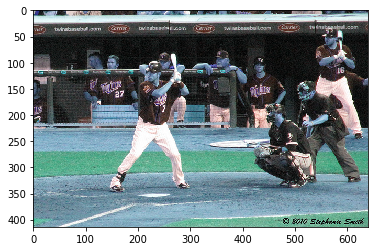

In [10]:
show_image(idx=1, train=True)

# Pre-Trained Image Model (VGG16)

In [11]:
# Download VGG16 model along with the fully-connected layers
image_model = VGG16(include_top=True, weights='imagenet')
image_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [12]:
# Extract the second last layer which is a fully-connected layer
transfer_layer = image_model.get_layer('fc2')

In [13]:
# Create the encoder model
image_model_transfer = Model(inputs=image_model.input, outputs=transfer_layer.output)

In [14]:
# Get the expected input size of the pre-trained network
img_size = K.int_shape(image_model.input)[1:3]
img_size

(224, 224)

In [15]:
# Get the expected output shape of the pre-trained network
transfer_values_size = K.int_shape(transfer_layer.output)[1]
transfer_values_size

4096

### Process Images

In [16]:
def print_progress_bar(iteration, total):
    percent = ("{0:.1f}").format(100 * (iteration / float(total)))
    filled_length = int(100 * iteration // total)
    bar = '█' * filled_length + '-' * (100 - filled_length)
    print('\r |%s| %s%% ' % (bar, percent), end = '\r')
    # Print New Line on Complete
    if iteration == total: 
        print()

In [17]:
def process_images(data_dir, filenames, batch_size=32):
    """
    Process all the given files in the given data_dir using the
    pre-trained image-model and return their transfer-values.
    
    The images are processed in batches to save
    memory and improve efficiency.
    """
    
    # Number of images to process.
    num_images = len(filenames)

    # Pre-allocate input-batch-array for images.
    shape = (batch_size,) + img_size + (3,)
    image_batch = np.zeros(shape=shape, dtype=np.float32)

    # Pre-allocate output-array for transfer-values.
    shape = (num_images, transfer_values_size)
    transfer_values = np.zeros(shape=shape, dtype=np.float32)

    # Initialize index into the filenames.
    start_index = 0

    # Process batches of image-files.
    while start_index < num_images:
        # Print the percentage-progress.
        print_progress_bar(start_index, num_images)

        # End-index for this batch.
        end_index = start_index + batch_size

        # Ensure end-index is within bounds.
        if end_index > num_images:
            end_index = num_images

        # The last batch may have a different batch-size.
        current_batch_size = end_index - start_index

        # Load all the images in the batch.
        for i, filename in enumerate(filenames[start_index:end_index]):
            # Path for the image-file.
            path = os.path.join(data_dir, filename)
            
            # Load and resize the image.
            # This returns the image as a numpy-array.
            img = load_image(path, size=img_size)

            # Save the image for later use.
            image_batch[i] = img

        # Use the pre-trained image-model to process the image.
        # Note that the last batch may have a different size,
        # so we only use the relevant images.
        transfer_values_batch = \
            image_model_transfer.predict(image_batch[0:current_batch_size])

        # Save the transfer-values in the pre-allocated array.
        transfer_values[start_index:end_index] = \
            transfer_values_batch[0:current_batch_size]

        # Increase the index for the next loop-iteration.
        start_index = end_index

    # Print newline.
    print()

    return transfer_values

In [18]:
def process_images_train():
    print('Processing {0} images in training-set ...'.format(len(filenames_train)))

    # Path for the cache-file.
    cache_path = os.path.join(data_dir, 'transfer_values_train.pkl')

    # If the cache-file already exists then reload it,
    # otherwise process all images and save their transfer-values
    # to the cache-file so it can be reloaded quickly.
    transfer_values = cache(
        cache_path=cache_path,
        fn=process_images,
        data_dir=data_dir,
        filenames=filenames_train
    )

    return transfer_values

In [19]:
def process_images_val():
    print('Processing {0} images in validation-set ...'.format(len(filenames_val)))

    # Path for the cache-file.
    cache_path = os.path.join(data_dir, 'transfer_values_val.pkl')

    # If the cache-file already exists then reload it,
    # otherwise process all images and save their transfer-values
    # to the cache-file so it can be reloaded quickly.
    transfer_values = cache(
        cache_path=cache_path,
        fn=process_images,
        data_dir=data_dir,
        filenames=filenames_val
    )

    return transfer_values

In [20]:
%%time
transfer_values_train = process_images_train()
print("dtype:", transfer_values_train.dtype)
print("shape:", transfer_values_train.shape)

Processing 19324 images in training-set ...
- Data loaded from cache-file: dataset/transfer_values_train.pkl
dtype: float32
shape: (19324, 4096)
CPU times: user 117 ms, sys: 437 ms, total: 555 ms
Wall time: 550 ms


In [21]:
%%time
transfer_values_val = process_images_val()
print("dtype:", transfer_values_val.dtype)
print("shape:", transfer_values_val.shape)

Processing 4832 images in validation-set ...
- Data loaded from cache-file: dataset/transfer_values_val.pkl
dtype: float32
shape: (4832, 4096)
CPU times: user 27 ms, sys: 102 ms, total: 129 ms
Wall time: 126 ms


# Tokenizer

In [34]:
mark_start = 'ssss '
mark_end = ' eeee'

In [35]:
def mark_captions(captions_list):
    """ Mark all the captions with the start and the end marker """
    captions_marked = [
        [mark_start + caption + mark_end for caption in captions] for captions in captions_list
    ]
    
    return captions_marked

In [36]:
captions_train_marked = mark_captions(captions_train)
print('Marked captions:')
captions_train_marked[0]

Marked captions:


['ssss A woman skiing in the snow followed by more skiers. eeee',
 'ssss The skiers are all lined up single file. eeee',
 'ssss A group of skiers in a line skiing down the road. eeee',
 'ssss A line of young skiers ski down a gentle slope. eeee',
 'ssss A girl skis first in a line of skiers. eeee']

In [37]:
print('\nOriginal captions:')
captions_train[0]


Original captions:


['A woman skiing in the snow followed by more skiers.',
 'The skiers are all lined up single file.',
 'A group of skiers in a line skiing down the road.',
 'A line of young skiers ski down a gentle slope.',
 'A girl skis first in a line of skiers.']

In [38]:
def flatten(captions_list):
    """ Flatten all the captions into a single list """
    caption_list = [caption
                    for caption_list in captions_list
                    for caption in caption_list]
    
    return caption_list

In [39]:
captions_train_flat = flatten(captions_train_marked)

In [40]:
# Maximum number of most-frequent words to be considered from the training data
num_words = 10000

In [41]:
class TokenizerWrap(Tokenizer):
    """Wrap the Tokenizer-class from Keras with more functionality."""
    
    def __init__(self, texts, num_words=None):
        """
        :param texts: List of strings with the data-set.
        :param num_words: Max number of words to use.
        """

        Tokenizer.__init__(self, num_words=num_words)

        # Create the vocabulary from the texts.
        self.fit_on_texts(texts)

        # Create inverse lookup from integer-tokens to words.
        self.index_to_word = dict(zip(
            self.word_index.values(), self.word_index.keys()
        ))

    def token_to_word(self, token):
        """Lookup a single word from an integer-token."""

        word = " " if token == 0 else self.index_to_word[token]
        return word 

    def tokens_to_string(self, tokens):
        """Convert a list of integer-tokens to a string."""

        # Create a list of the individual words.
        words = [self.index_to_word[token] for token in tokens if token != 0]
        
        # Concatenate the words to a single string
        # with space between all the words.
        text = " ".join(words)

        return text
    
    def captions_to_tokens(self, captions_list):
        """
        Convert a list-of-list with text-captions to
        a list-of-list of integer-tokens.
        """
        
        # Note that text_to_sequences() takes a list of texts.
        tokens = [self.texts_to_sequences(caption_list) for caption_list in captions_list]
        
        return tokens

Create the tokenizer

In [42]:
%%time
tokenizer = TokenizerWrap(texts=captions_train_flat, num_words=num_words)

CPU times: user 1.67 s, sys: 4.01 ms, total: 1.67 s
Wall time: 1.67 s


In [43]:
# Get integer token for the start marker
token_start = tokenizer.word_index[mark_start.strip()]
token_start

2

In [44]:
# Get integer token for the end marker
token_end = tokenizer.word_index[mark_end.strip()]
token_end

3

Convert all the captions from the training-set to sequence of integer tokens.

In [45]:
%%time
tokens_train = tokenizer.captions_to_tokens(captions_train_marked)

CPU times: user 1.76 s, sys: 20.9 ms, total: 1.78 s
Wall time: 1.78 s


In [47]:
print('Token sequences for the first image in the training-set:')
tokens_train[0]

Token sequences for the first image in the training-set:


[[2, 1, 30, 61, 6, 4, 24, 1530, 108, 1582, 115, 3],
 [2, 4, 115, 32, 307, 499, 51, 629, 1714, 3],
 [2, 1, 36, 8, 115, 6, 1, 304, 61, 33, 4, 226, 3],
 [2, 1, 304, 8, 27, 115, 64, 33, 1, 1057, 57, 3],
 [2, 1, 73, 43, 510, 6, 1, 304, 8, 115, 3]]

In [48]:
print('\nCorresponding captions:')
captions_train_marked[0]


Corresponding captions:


['ssss A woman skiing in the snow followed by more skiers. eeee',
 'ssss The skiers are all lined up single file. eeee',
 'ssss A group of skiers in a line skiing down the road. eeee',
 'ssss A line of young skiers ski down a gentle slope. eeee',
 'ssss A girl skis first in a line of skiers. eeee']

# Data Generator

Each image in the training-set has at least 5 captions describing the contents of the image. The neural network will be trained with batches of transfer-values for the images and sequences of integer-tokens for the captions. If we were to have matching numpy arrays for the training-set, we would either have to only use a single caption for each image and ignore the rest of this valuable data, or we would have to repeat the image transfer-values for each of the captions, which would waste a lot of memory.

A better solution is to create a custom data-generator for Keras that will create a batch of data with randomly selected transfer-values and token-sequences.

This helper-function returns a list of random token-sequences for the images with the given indices in the training-set.

In [53]:
def get_random_caption_tokens(idx):
    """
    Given a list of indices for images in the training-set,
    select a token-sequence for a random caption,
    and return a list of all these token-sequences.
    """
    
    # Initialize an empty list for the results.
    result = []

    # For each of the indices.
    for i in idx:
        # The index i points to an image in the training-set.
        # Each image in the training-set has at least 5 captions
        # which have been converted to tokens in tokens_train.
        # We want to select one of these token-sequences at random.

        # Get a random index for a token-sequence.
        j = np.random.choice(len(tokens_train[i]))

        # Get the j'th token-sequence for image i.
        tokens = tokens_train[i][j]

        # Add this token-sequence to the list of results.
        result.append(tokens)

    return result

In [54]:
def batch_generator(batch_size):
    """
    Generator function for creating random batches of training-data.
    
    Note that it selects the data completely randomly for each
    batch, corresponding to sampling of the training-set with
    replacement. This means it is possible to sample the same
    data multiple times within a single epoch - and it is also
    possible that some data is not sampled at all within an epoch.
    However, all the data should be unique within a single batch.
    """

    # Infinite loop.
    while True:
        # Get a list of random indices for images in the training-set.
        idx = np.random.randint(num_images_train, size=batch_size)
        
        # Get the pre-computed transfer-values for those images.
        # These are the outputs of the pre-trained image-model.
        transfer_values = transfer_values_train[idx]

        # For each of the randomly chosen images there are
        # at least 5 captions describing the contents of the image.
        # Select one of those captions at random and get the
        # associated sequence of integer-tokens.
        tokens = get_random_caption_tokens(idx)

        # Count the number of tokens in all these token-sequences.
        num_tokens = [len(t) for t in tokens]
        
        # Max number of tokens.
        max_tokens = np.max(num_tokens)
        
        # Pad all the other token-sequences with zeros
        # so they all have the same length and can be
        # input to the neural network as a numpy array.
        tokens_padded = pad_sequences(
            tokens,
            maxlen=max_tokens,
            padding='post',
            truncating='post'
        )
        
        # Further prepare the token-sequences.
        # The decoder-part of the neural network
        # will try to map the token-sequences to
        # themselves shifted one time-step.
        decoder_input_data = tokens_padded[:, 0:-1]
        decoder_output_data = tokens_padded[:, 1:]

        # Dict for the input-data. Because we have
        # several inputs, we use a named dict to
        # ensure that the data is assigned correctly.
        x_data = {
            'decoder_input': decoder_input_data,
            'transfer_values_input': transfer_values
        }

        # Dict for the output-data.
        y_data = {
            'decoder_output': decoder_output_data
        }
        
        yield (x_data, y_data)

In [55]:
batch_size = 128
generator = batch_generator(batch_size=batch_size)
batch = next(generator)
batch_x = batch[0]
batch_y = batch[1]

In [56]:
# Example of the transfer-values for the first image in the batch
batch_x['transfer_values_input'][0]

array([-0.        ,  0.16082239,  1.719369  , ..., -0.        ,
       -0.        ,  0.8369916 ], dtype=float32)

In [57]:
# Example of the token-sequence for the first image in the batch
# This is the input to the decoder-part of the neural network
batch_x['decoder_input'][0]

array([ 2,  1, 11, 16, 90,  5, 53,  8,  1, 11, 48,  3,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0], dtype=int32)

In [58]:
# This is the token-sequence for the output of the decoder
# Note how it is the same as the sequence above, except it is shifted one time-step
batch_y['decoder_output'][0]

array([ 1, 11, 16, 90,  5, 53,  8,  1, 11, 48,  3,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0], dtype=int32)

## Steps Per Epoch

One epoch is a complete processing of the training-set. We would like to process each image and caption pair only once per epoch. However, because each batch is chosen completely at random in the above batch-generator, it is possible that an image occurs in multiple batches within a single epoch, and it is possible that some images may not occur in any batch at all within a single epoch.

Nevertheless, we still use the concept of an 'epoch' to measure approximately how many iterations of the training-data we have processed. But the data-generator will generate batches for eternity, so we need to manually calculate the approximate number of batches required per epoch.

In [59]:
# Number of captions for each image in the training-set
num_captions_train = [len(captions) for captions in captions_train]

# Total number of captions in the training-set
total_num_captions_train = np.sum(num_captions_train)

# Approximate number of batches required per epoch,
# if we want to process each caption and image pair once per epoch
steps_per_epoch = int(total_num_captions_train / batch_size)
steps_per_epoch

755

# Recurrent Neural Network

## Embedding Layer

In [51]:
def read_glove_vecs(glove_file):
    print('Creating word to vec map...')
    with open(glove_file, 'r') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float32)
    print('Done!')
    return word_to_vec_map

In [52]:
# load embeddings
word_to_vec_map = read_glove_vecs('{}/glove.6B.100d.txt'.format(data_dir))

Creating word to vec map...
Done!


In [60]:
# assign embeddings values to custom tokens
size = word_to_vec_map['unk'].shape

word_to_vec_map[mark_start.strip()] = np.random.uniform(low=-1.0, high=1.0, size=size)
word_to_vec_map[mark_end.strip()] = np.random.uniform(low=-1.0, high=1.0, size=size)

In [66]:
def create_embedding_layer(word_to_index, word_to_vec_map, num_words):
    """ Create a Keras Embedding() layer and load in pre-trained GloVe 100-dimensional vectors
        @params:
        :word_to_index -- dictionary containing the each word mapped to its index
        :word_to_vec_map -- dictionary mapping words to their GloVe vector representation
        :num_words -- number of words in the vocabulary
        
        @return:
        :decoder_embedding -- pretrained layer Keras instance
    """
    
    vocabulary_length = num_words + 1  # adding 1 to fit Keras embedding (requirement)
    embedding_dimensions = word_to_vec_map['unk'].shape[0]  # define dimensionality of GloVe word vectors (= 100)
    
    embedding_matrix = np.zeros((vocabulary_length, embedding_dimensions))  # initialize with zeros
    for word, index in word_to_index.items():
        try:
            embedding_matrix[index, :] = word_to_vec_map[word]
        except KeyError:
            embedding_matrix[index, :] = word_to_vec_map['unk']
    
    # we don't want the embeddings to be updated, thus trainable parameter is set to False
    decoder_embedding = Embedding(
        input_dim=vocabulary_length,
        output_dim=embedding_dimensions,
        trainable=False,
        name='decoder_embedding'
    )
    decoder_embedding.build((None,))
    decoder_embedding.set_weights([embedding_matrix])  # with this the layer is now pretrained
    
    return decoder_embedding

## Create RNN

In [62]:
# Internal state-sizes of GRUs
state_size = 512

In [63]:
# This inputs transfer-values to the decoder
transfer_values_input = Input(shape=(transfer_values_size,), name='transfer_values_input')

The transfer-values are used to initialize the internal states of the GRU units. This informs the GRU units of the contents of the images. The transfer-values are vectors of length 4096 but the size of the internal states of the GRU units are only 512, so fully-connected layer is used to map the vectors from 4096 to 512 elements.

In [64]:
decoder_transfer_map = Dense(state_size,
                             activation='tanh',
                             name='decoder_transfer_map')

In [65]:
# Input for token-sequences to the decoder
# Using 'None' in the shape means that the token-sequences can have arbitrary lengths
decoder_input = Input(shape=(None, ), name='decoder_input')

In [67]:
# Embedding-layer which converts sequences of integer-tokens to sequences of vectors
decoder_embedding = create_embedding_layer(tokenizer.word_index, word_to_vec_map, num_words)

In [68]:
# The 3 GRU layers of the decoder
decoder_gru1 = GRU(state_size, name='decoder_gru1',
                   return_sequences=True)
decoder_gru2 = GRU(state_size, name='decoder_gru2',
                   return_sequences=True)
decoder_gru3 = GRU(state_size, name='decoder_gru3',
                   return_sequences=True)

The GRU layers output a tensor with shape `[batch_size, sequence_length, state_size]`, where each "word" is encoded as a vector of length `state_size`. We need to convert this into sequences of integer-tokens that can be interpreted as words from our vocabulary.

Note that the activation-function is set to `linear` instead of `softmax` as we would normally use for one-hot encoded outputs, because there is apparently a bug in Keras so we need to make our own loss-function, as described in detail further below.

In [69]:
decoder_dense = Dense(num_words,
                      activation='linear',
                      name='decoder_output')

### Attention Mechanism

In [ ]:
# TODO: Add attention

# Connect and Create the Training Model

In [70]:
def connect_decoder(transfer_values):
    # Map the transfer-values so the dimensionality matches
    # the internal state of the GRU layers. This means
    # we can use the mapped transfer-values as the initial state
    # of the GRU layers.
    initial_state = decoder_transfer_map(transfer_values)

    # Start the decoder-network with its input-layer.
    net = decoder_input
    
    # Connect the embedding-layer.
    net = decoder_embedding(net)
    
    # Connect all the GRU layers.
    net = decoder_gru1(net, initial_state=initial_state)
    net = decoder_gru2(net, initial_state=initial_state)
    net = decoder_gru3(net, initial_state=initial_state)

    # Connect the final dense layer that converts to
    # one-hot encoded arrays.
    decoder_output = decoder_dense(net)
    
    return decoder_output

In [71]:
decoder_output = connect_decoder(transfer_values=transfer_values_input)

decoder_model = Model(
    inputs=[transfer_values_input, decoder_input],
    outputs=[decoder_output]
)

In [72]:
decoder_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_input (InputLayer)      (None, None)         0                                            
__________________________________________________________________________________________________
transfer_values_input (InputLay (None, 4096)         0                                            
__________________________________________________________________________________________________
decoder_embedding (Embedding)   (None, None, 100)    1000100     decoder_input[0][0]              
__________________________________________________________________________________________________
decoder_transfer_map (Dense)    (None, 512)          2097664     transfer_values_input[0][0]      
__________________________________________________________________________________________________
decoder_gr

### Loss Function

In [73]:
def sparse_cross_entropy(y_true, y_pred):
    """
    Calculate the cross-entropy loss between y_true and y_pred.
    
    y_true is a 2-rank tensor with the desired output.
    The shape is [batch_size, sequence_length] and it
    contains sequences of integer-tokens.

    y_pred is the decoder's output which is a 3-rank tensor
    with shape [batch_size, sequence_length, num_words]
    so that for each sequence in the batch there is a one-hot
    encoded array of length num_words.
    """

    # Calculate the loss. This outputs a
    # 2-rank tensor of shape [batch_size, sequence_length]
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true,
                                                          logits=y_pred)

    # Keras may reduce this across the first axis (the batch)
    # but the semantics are unclear, so to be sure we use
    # the loss across the entire 2-rank tensor, we reduce it
    # to a single scalar with the mean function.
    loss_mean = tf.reduce_mean(loss)

    return loss_mean

## Compile the Training Model

In [74]:
optimizer = RMSprop(lr=1e-3)

There seems to be a bug in Keras that it cannot automatically deduce the correct shape of the decoder's output data. We therefore need to manually create a placeholder variable for the decoder's output. The shape is set to `(None, None)` which means the batch can have an arbitrary number of sequences, which can have an arbitrary number of integer-tokens.

In [75]:
decoder_target = tf.placeholder(dtype='int32', shape=(None, None))

In [76]:
decoder_model.compile(optimizer=optimizer,
                      loss=sparse_cross_entropy,
                      target_tensors=[decoder_target])

### Callback Functions

In [78]:
path_checkpoint = 'checkpoint_new.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      verbose=1,
                                      save_weights_only=True)

In [79]:
callback_tensorboard = TensorBoard(log_dir='./logs/',
                                   histogram_freq=0,
                                   write_graph=False)

In [80]:
callbacks = [callback_checkpoint, callback_tensorboard]

### Load Checkpoint

In [81]:
try:
    decoder_model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

Error trying to load checkpoint.
Unable to open file (unable to open file: name = 'checkpoint_new.keras', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


### Train the Model

In [82]:
%%time
decoder_model.fit_generator(generator=generator,
                            steps_per_epoch=steps_per_epoch,
                            epochs=20,
                            callbacks=callbacks)

Epoch 1/20
754/755 [============================>.] - ETA: 2s - loss: 1.7078
Epoch 00001: saving model to checkpoint_new.keras
755/755 [==============================] - 1972s 3s/step - loss: 1.7075
Epoch 2/20
754/755 [============================>.] - ETA: 2s - loss: 1.2153
Epoch 00002: saving model to checkpoint_new.keras
755/755 [==============================] - 2014s 3s/step - loss: 1.2156
Epoch 3/20
 74/755 [=>............................] - ETA: 29:00 - loss: 1.2041

KeyboardInterrupt: 

# Generate Captions

In [ ]:
def generate_caption(image_path, max_tokens=30):
    """
    Generate a caption for the image in the given path.
    The caption is limited to the given number of tokens (words).
    """

    # Load and resize the image.
    image = load_image(image_path, size=img_size)
    
    # Expand the 3-dim numpy array to 4-dim
    # because the image-model expects a whole batch as input,
    # so we give it a batch with just one image.
    image_batch = np.expand_dims(image, axis=0)

    # Process the image with the pre-trained image-model
    # to get the transfer-values.
    transfer_values = image_model_transfer.predict(image_batch)

    # Pre-allocate the 2-dim array used as input to the decoder.
    # This holds just a single sequence of integer-tokens,
    # but the decoder-model expects a batch of sequences.
    shape = (1, max_tokens)
    decoder_input_data = np.zeros(shape=shape, dtype=np.int)

    # The first input-token is the special start-token for 'ssss '.
    token_int = token_start

    # Initialize an empty output-text.
    output_text = ''

    # Initialize the number of tokens we have processed.
    count_tokens = 0

    # While we haven't sampled the special end-token for ' eeee'
    # and we haven't processed the max number of tokens.
    while token_int != token_end and count_tokens < max_tokens:
        # Update the input-sequence to the decoder
        # with the last token that was sampled.
        # In the first iteration this will set the
        # first element to the start-token.
        decoder_input_data[0, count_tokens] = token_int

        # Wrap the input-data in a dict for clarity and safety,
        # so we are sure we input the data in the right order.
        x_data = {
            'transfer_values_input': transfer_values,
            'decoder_input': decoder_input_data
        }

        # Note that we input the entire sequence of tokens
        # to the decoder. This wastes a lot of computation
        # because we are only interested in the last input
        # and output. We could modify the code to return
        # the GRU-states when calling predict() and then
        # feeding these GRU-states as well the next time
        # we call predict(), but it would make the code
        # much more complicated.
        
        # Input this data to the decoder and get the predicted output.
        decoder_output = decoder_model.predict(x_data)

        # Get the last predicted token as a one-hot encoded array.
        # Note that this is not limited by softmax, but we just
        # need the index of the largest element so it doesn't matter.
        token_onehot = decoder_output[0, count_tokens, :]

        # Convert to an integer-token.
        token_int = np.argmax(token_onehot)

        # Lookup the word corresponding to this integer-token.
        sampled_word = tokenizer.token_to_word(token_int)

        # Append the word to the output-text.
        output_text += " " + sampled_word

        # Increment the token-counter.
        count_tokens += 1

    # This is the sequence of tokens output by the decoder.
    output_tokens = decoder_input_data[0]

    # Plot the image.
    plt.imshow(image)
    plt.show()
    
    # Print the predicted caption.
    print("Predicted caption:")
    print(output_text)
    print()

In [ ]:
generate_caption('dataset/' + filenames_val[120])

### Generate both true and predicted labels

In [ ]:
def generate_caption_coco(idx, train=False):
    """
    Generate a caption for an image in the COCO data-set.
    Use the image with the given index in either the
    training-set (train=True) or validation-set (train=False).
    """
    
    if train:
        # Use image and captions from the training-set.
        filename = filenames_train[idx]
        captions = captions_train[idx]
    else:
        # Use image and captions from the validation-set.
        filename = filenames_val[idx]
        captions = captions_val[idx]

    # Path for the image-file.
    path = os.path.join(data_dir, filename)

    # Use the model to generate a caption of the image.
    generate_caption(image_path=path)

    # Print the true captions from the data-set.
    print("True captions:")
    for caption in captions:
        print(caption)

In [ ]:
generate_caption_coco(idx=1, train=False)